# Imports

The tutorial works best on a machine with GPU capabilities and has not been tested on a CPU-only machine. 

**To run the tutorial using a local Jupyter notebook server:**

1.   Clone the [PORCELAN GitHub repo](https://github.com/uhlerlab/).
2.   Create a Python 3.8 virtual environment and install the required packages.
3.   Start a jupyter notebook server within in the main `porcelan` directory.
4.   Open this notebook on your jupyter notebook server. Alternatively you can connect a Google Colab notebook to your local jupyter notebook server as described [here](https://research.google.com/colaboratory/local-runtimes.html).


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import dendropy
from statsmodels.nonparametric.smoothers_lowess import lowess
import scanpy
from torch import nn
import torch
from ete3 import Tree
import gc
import seaborn as sns
import gseapy
import time
import pickle
import random

import os
import sys
sys.path.append('..')


from tree_util import get_apn_dist_triplet_lut, dist_matrix_to_numpy, augment_tree_with_weights
from model import AutoEncoder, TreeGeneModel
from training import train, train_triplet, optimize_weights
from tree_util import get_apn_dist_triplet_lut, dist_matrix_to_numpy, get_tree_dists, get_node_and_edge_data
from plotting import interactive_plot, get_tsne, nice_colors, double_tree_plot, kp_color_domain
from perm_util import extract_subsets_with_height, subset_labels
from scores import get_lac_for_all_genes, get_expected_lac_bmtm_height_perm, get_perm_dists

# Download example data and preprocessing

PORCELAN is designed to analyze single cell lineage tracing datasets with gene expression paired with all lineage tree leaves.

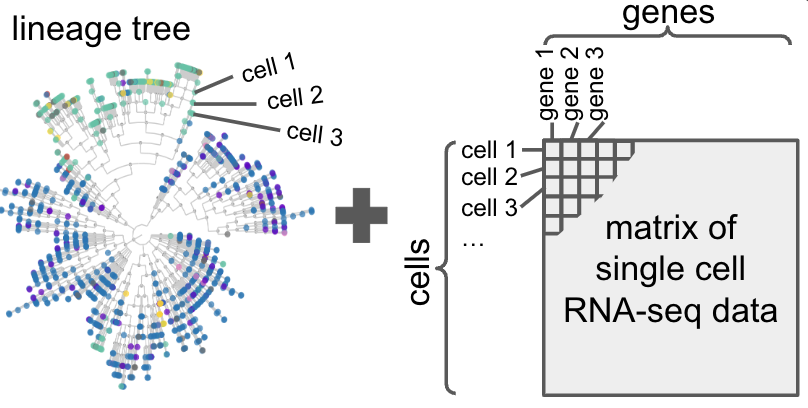

In this tutorial we'll use tumor 3515_Lkb1_T1 and its metastasis from [Yang et al.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9452598/).


The code cell below downloads the full dataset from [https://zenodo.org/records/5847462](https://zenodo.org/records/5847462). If you have already downloaded the data somewhere else you can skip the cell below and instead modify the `raw_data_path` to point to that directory.



In [5]:
# @title Download the data

raw_data_path = './tutorial/data/'

os.makedirs(raw_data_path, exist_ok=True)

! wget -P $raw_data_path -O KPTracer-Data.tar.gz 'https://zenodo.org/records/5847462/files/KPTracer-Data.tar.gz?download=1'
! tar -xzf KPTracer-Data.tar.gz -C $raw_data_path
! rm KPTracer-Data.tar.gz

--2025-04-30 21:18:30--  https://zenodo.org/records/5847462/files/KPTracer-Data.tar.gz?download=1
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.45.92, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1304975216 (1.2G) [application/octet-stream]
Saving to: ‘KPTracer-Data.tar.gz’

r.gz                100%[===================>]   1.21G   671KB/s    in 25m 10s 

2025-04-30 21:43:41 (844 KB/s) - ‘KPTracer-Data.tar.gz’ saved [1304975216/1304975216]



In [2]:
# raw_data_path = '/your/custom/path/where/you/downloaded/the/dataset/'
raw_data_path = './tutorial/data/'
data_path = './tutorial/data/preprocessed/'
os.makedirs(data_path, exist_ok=True)


In [3]:
# @title Extract and preprocess data for tumor 3515_Lkb1_T1 and metastases

# load the data files
meta_df = pd.read_csv(f'{raw_data_path}/KPTracer-Data/KPTracer_meta.csv', index_col=0)
adata = scanpy.read_h5ad(f'{raw_data_path}/KPTracer-Data/expression/adata_processed.combined.h5ad')

# select data for one tumor and its metastasis
name = '3515_Lkb1_T1_Fam'
prefix = '3515_Lkb1'

SUBSET_SIZE = 500  # Adjusted for 16GB RAM
RANDOM_SEED = 42

tumor_meta = meta_df[meta_df['Tumor'].str.startswith(prefix) & meta_df['TS_Present'] & meta_df['RNA_Present']]
tumor_adata = adata[adata.obs['Tumor'].str.startswith(prefix)]

tree = dendropy.Tree.get(path=f'{raw_data_path}/KPTracer-Data/trees/{name}_tree.nwk', schema='newick')

# find intersection of cells in both modalities
tree_cells = set([c.taxon.label for c in tree.leaf_nodes()])
meta_cells = set(tumor_meta.index)
adata_cells = set(tumor_adata.obs.index)
print(len(tree_cells), len(meta_cells), len(adata_cells))
print('meta but not tree (vice versa): ', len(meta_cells - tree_cells), '(', len(tree_cells - meta_cells), ')')
print('tree but not adata (vice versa): ', len(tree_cells - adata_cells), '(', len(adata_cells - tree_cells), ')')
print('meta but not adata (vice versa): ', len(meta_cells - adata_cells), '(', len(adata_cells - meta_cells), ')')

intersect_cells = meta_cells & tree_cells & adata_cells
print('full intersection:', len(intersect_cells))

# sample a subset
random.seed(RANDOM_SEED)
if len(intersect_cells) > SUBSET_SIZE:
    intersect_cells = random.sample(intersect_cells, SUBSET_SIZE)

print('using subset:', len(intersect_cells))

# prune tree
tree.retain_taxa_with_labels(intersect_cells, suppress_unifurcations=True)
for edge in tree.edges():  # set edge lengths to 1 so all are equal
  edge.length = 1
print('height:', tree.max_distance_from_root())
print('leaves:', len(tree.leaf_nodes()))
tree.write(path=f'{data_path}/{name}_pruned.nwk', schema='newick')


pruned_adata = tumor_adata[tumor_adata.obs.index.isin(intersect_cells)]
# remove rare genes
keep = np.array((pruned_adata.X > 0).sum(axis=0) >= 10).flatten()
print('genes expressed in 10 or more cells:', np.sum(keep), 'out of', pruned_adata.X.shape[1])
gene_names = adata.var_names[keep]
gene_counts = pruned_adata.X[:, keep].toarray()
# L1 normalization on cells to [0, 10000]
cell_sums = gene_counts.sum(axis=1)
gene_counts[cell_sums > 0] = gene_counts[cell_sums > 0] / cell_sums[cell_sums > 0].reshape(-1, 1)
gene_counts *= 10000
# log2(1 + x) tranform
gene_counts = np.log2(1 + gene_counts)

# save pre-processed gene expression
df = pd.DataFrame(gene_counts)
df.columns = gene_names
df.to_csv(f'{data_path}/{name}_normalized_log_counts.txt', index=False)

# save cell names
pd.DataFrame(pruned_adata.obs.index).to_csv(f'{data_path}/{name}_cells.txt', index=False, columns=[0], header=False)

# save tumor association
tumor_meta.loc[pruned_adata.obs.index].to_csv(f'{data_path}/{name}_tumors.txt', index=False, columns=['Tumor'], header=False)

# save cell types
pruned_adata.obs[['Cluster-Name']].to_csv(f'{data_path}/{name}_cell_types.txt', header=False, index=False)

1878 2229 2708
meta but not tree (vice versa):  351 ( 0 )
tree but not adata (vice versa):  0 ( 830 )
meta but not adata (vice versa):  20 ( 499 )
full intersection: 1878
using subset: 500
height: 20.0
leaves: 500
genes expressed in 10 or more cells: 620 out of 4000


# Applying PORCELAN

There are three questions addressed by PORCELAN:
* (Q1) How can we learn representations of cells capturing both lineage and gene expression information?
* (Q2) Which genes are most informative about lineage and in which subtrees lineage and gene expression relationships are tightly coupled?
* (Q3) How well is lineage tree structure represented in gene expression, and how does this vary for different lineage resolutions?

Each question is answered with a different part of our method. In this section we use PORCELAN to answer each question for an example tumor.


## (Q1) Learning lineage tree-structured gene expression representations

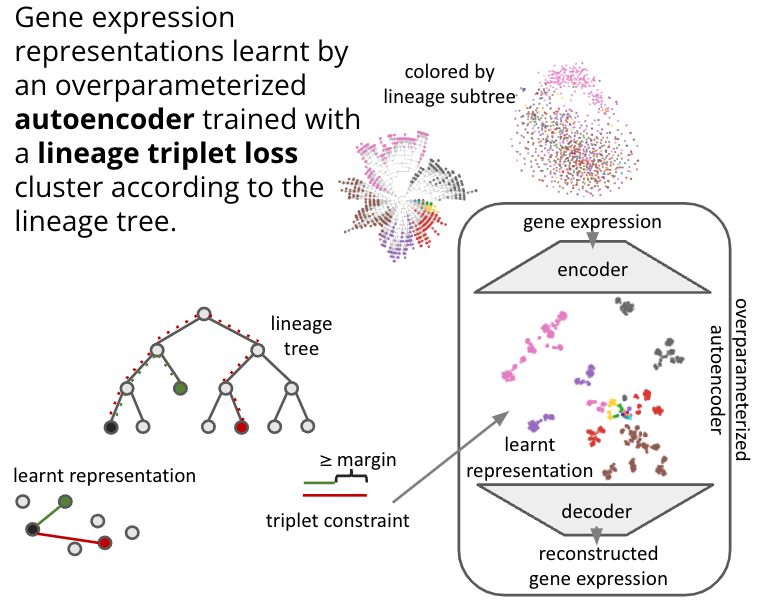

In this examples we apply the representation learning framework to the top 100 highly variable genes. However, you could also select larger gene set or other data types if you modify the autoencoder architecture appropriately.

In [4]:
results_path = './tutorial/results/'
results_path_ae = './tutorial/results/ae'
os.makedirs(results_path, exist_ok=True)
os.makedirs(results_path_ae, exist_ok=True)

values to clip: Sox17     0
Tcea1     0
Tram1     0
Sdhaf4    0
Ptp4a1    0
         ..
Sema4g    0
Mrpl43    0
Cuedc2    0
Mirt1     0
mt-Nd2    0
Length: 620, dtype: int64
Top 100 HVG in order: ['Sftpc' 'Ly6d' 'Car2' 'Tff1' 'Clu' 'Il33' 'Sftpb' 'Spp1' 'Areg' 'Cxcl5'
 'Stmn2' 'Plac8' 'Lyz2' 'Mcpt1' 'Krt20' 'Ager' 'Slc34a2' 'Nefl'
 'Hmga1-rs1' 'Crlf1' 'Trpm5' 'Hp' 'Cldn18' 'Far1' 'S100a14' 'Cldn4'
 'H2-Aa' 'Btg2' 'Pgk1' 'Id3' 'Fosb' 'Cited2' 'Foxq1' 'A630076J17Rik'
 'Sox4' 'Onecut2' 'Egfl6' 'Ctsh' 'Ier2' 'Atxn7l2' 'Tspan1' 'Elf3' 'Egr1'
 'Ucp2' 'Cldn3' 'Sox17' 'Plppr4' 'Il6' 'Ap3b2' 'Ctsl' 'Cd24a' 'Ovol1'
 'Slc25a4' 'Ier5' 'Mgst1' 'Ahnak' 'Cited4' 'Maff' 'Serpinb6b' 'R3hdml'
 'Sertad1' 'Hist1h2ap' 'Krt12' 'Jund' 'Akr1b3' 'Tubb5' 'Cebpb' 'Gm19325'
 'Klf5' 'Ugdh' 'Ifi27' 'Sms' 'Pttg1' 'Mirt1' 'Actn1' 'Sfpq' 'Gnl3'
 'Malat1' 'Mrps6' 'Sbk1' 'Ssrp1' 'Fyn' 'Siva1' 'Krt19' 'Cbr1' 'Wbp5'
 'Pdp2' 'Oasl1' 'Gsr' 'Rfx3' 'Ehf' 'Maged1' 'Mat2a' 'Cd81' 'Sumo3' 'Tkt'
 'Pdlim7' 'Ube2s' 'Psmc2' 'Nradd']

/tmp/ipykernel_88326/124493663.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


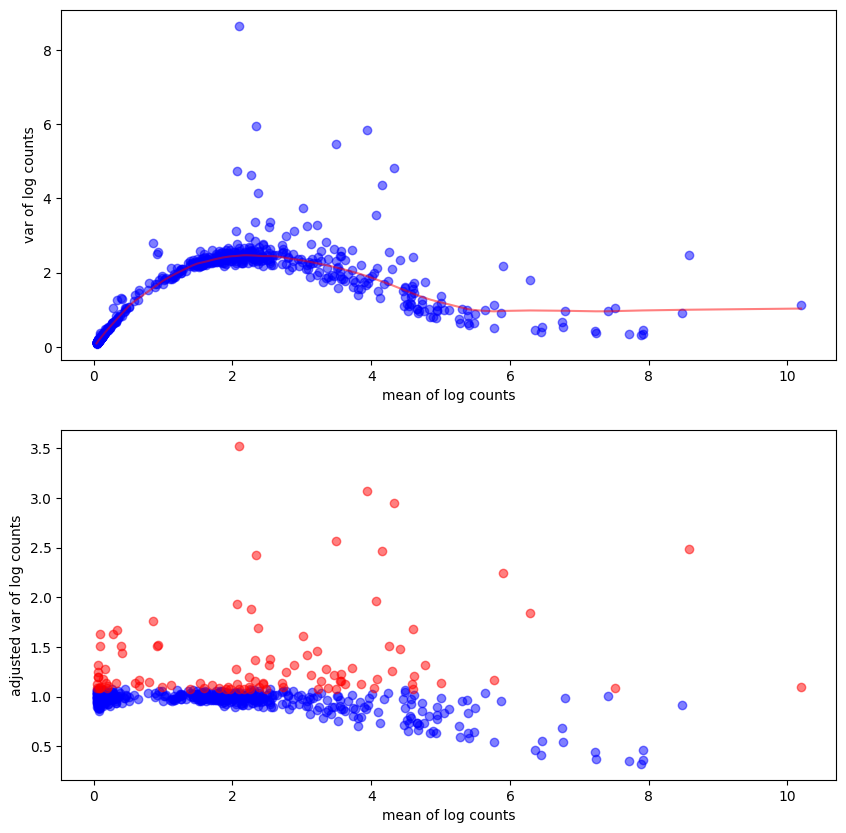

In [5]:
# @title Find highly variable genes

expression = pd.read_csv(f'{data_path}/{name}_normalized_log_counts.txt')

gene_stats = pd.DataFrame()
gene_stats.index = expression.columns
gene_stats['mean'] = expression.mean(axis=0)
gene_stats['var'] = expression.var(axis=0)
gene_stats['pred var'] = lowess(gene_stats['var'], gene_stats['mean'], return_sorted=False, frac=1/8)

fig, (ax, ax2) = plt.subplots(2, 1, figsize=(10, 10))
ax.plot(gene_stats['mean'], gene_stats['var'], 'ob', alpha=0.5)
gene_stats_sorted = gene_stats.sort_values('mean')
ax.plot(gene_stats_sorted['mean'], gene_stats_sorted['pred var'], '-r', alpha=0.5)
ax.set_xlabel('mean of log counts')
ax.set_ylabel('var of log counts')

adj_expression = (expression - expression.mean(axis=0)) / np.sqrt(gene_stats['pred var'].values)
print('values to clip:', (np.abs(adj_expression) > np.sqrt(len(expression))).sum())
adj_expression = np.clip(adj_expression, -np.sqrt(len(expression)), np.sqrt(len(expression)))

gene_stats['adj. var'] = adj_expression.var(axis=0)
gene_stats = gene_stats.sort_values('adj. var', ascending=False)
gene_stats['hvg'] = 100 * [True] + (len(gene_stats) - 100) * [False]

ax2.plot(gene_stats[~gene_stats['hvg']]['mean'], gene_stats[~gene_stats['hvg']]['adj. var'], 'ob', alpha=0.5)
ax2.plot(gene_stats[gene_stats['hvg']]['mean'], gene_stats[gene_stats['hvg']]['adj. var'], 'or', alpha=0.5)
ax2.set_xlabel('mean of log counts')
ax2.set_ylabel('adjusted var of log counts')
fig.show()

hvg_genes = gene_stats[gene_stats['hvg']].index
print('Top 100 HVG in order:', hvg_genes.values)
np.savetxt(f'{data_path}/{name}_hvg_genes.txt', hvg_genes, fmt='%s')

epoch: 500; recon: 0.001584923156770; : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:07<00:00, 67.67it/s]


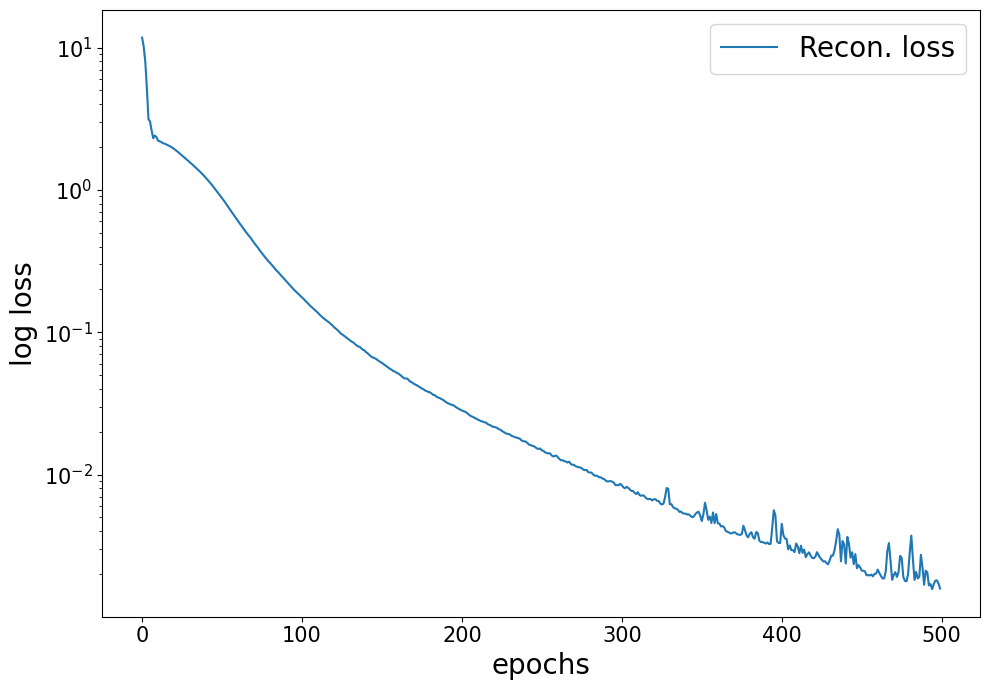

In [6]:
# @title Pre-train autoencoder to reconstruct gene expression

with open(f'{data_path}/{name}_hvg_genes.txt') as f:
  hvg_genes = np.array(f.read().splitlines())
with open(f'{data_path}/{name}_cells.txt') as f:
  labels_in_order = np.array(f.read().splitlines())
expression = pd.read_csv(f'{data_path}/{name}_normalized_log_counts.txt')
expression.index = labels_in_order


model = AutoEncoder(input_dim=len(hvg_genes), hidden_dim=1000, enc_layers=2, non_linearity=nn.LeakyReLU())
loss_plot = train(model, model_path=f'{results_path}/ae/{name}_AELR-2-1000_lr1em4_e500_b128_hvg.pt',
                  gene_matrix=expression[hvg_genes].values, num_epochs=500, device='cuda:0',
                  n_genes=len(hvg_genes), batch_size=128, lr=1e-4, training_seed=88232)

In [7]:
# # @title Define valid triplets based on the lineage tree

tree = dendropy.Tree.get(path=f'{data_path}/{name}_pruned.nwk', schema='newick')
with open(f'{data_path}/{name}_cells.txt') as f:
  cell_names = np.array(f.read().splitlines())
# computing the phylogenetic_distance_matrix with dendropy can take a few minutes
dist_matrix = dist_matrix_to_numpy(tree.phylogenetic_distance_matrix(), cell_names)
apn_lut = get_apn_dist_triplet_lut(dist_matrix)

with open(f'{data_path}/{name}_apn_pd_triplet_lut.npy', 'wb') as f:
  np.save(f, apn_lut)

# @title Define valid triplets (Optimized with TreeSwift + Progress)

# First install faster alternative
# @title Define valid triplets (Corrected TreeSwift Implementation)

# @title Define valid triplets (Corrected Node Handling)

# @title Define valid triplets (Optimized for Memory)

# import treeswift
# import numpy as np
# from tqdm.notebook import tqdm

# # Load pruned tree with TreeSwift (10x faster than DendroPy)
# tree = treeswift.read_tree_newick(f'{data_path}/{name}_pruned.nwk')

# # Create label-to-node mapping
# label_to_node = {node.label: node for node in tree.traverse_leaves()}

# # Load subsetted cells
# with open(f'{data_path}/{name}_cells.txt') as f:
#     cell_names = np.array(f.read().splitlines())
    
# # Verify all cells exist in the tree
# missing = [label for label in cell_names if label not in label_to_node]
# if missing:
#     raise ValueError(f"{len(missing)} cells missing from tree. First 5: {missing[:5]}")

# # Initialize distance matrix
# n_cells = len(cell_names)
# dist_matrix = np.zeros((n_cells, n_cells), dtype=np.float32)  # Use float32 to save memory

# # Calculate distances with progress bar
# with tqdm(total=n_cells*(n_cells-1)//2, desc='Calculating distances') as pbar:
#     for i in range(n_cells):
#         node_i = label_to_node[cell_names[i]]
#         for j in range(i+1, n_cells):
#             node_j = label_to_node[cell_names[j]]
#             dist_matrix[i,j] = tree.distance_between(node_i, node_j)
#             dist_matrix[j,i] = dist_matrix[i,j]  # Symmetric matrix
#             pbar.update(1)

# # Save results
# np.save(f'{data_path}/{name}_apn_pd_triplet_lut.npy', dist_matrix)




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 5206.43it/s]


loading model from path ./tutorial/results//ae/3515_Lkb1_T1_Fam_AELR-2-1000_lr1em4_e500_b128_hvg.pt
done loading model from path
Pre-trained recon. loss is 0.001604975899681449


epoch: 103; recon: 0.051997698843479; trip: 1.7929804325104; total: 1.844978094100952; :  20%|████████████████▌                                                                | 102/500 [00:06<00:27, 14.66it/s]

Saved model at ./tutorial/results//ae/3515_Lkb1_T1_Fam_AELR-2-1000_lr1em4_e500_b32_h1_pd_pre_ts12345_hvg_e100.pt


epoch: 252; recon: 0.031388863921165; trip: 0.0189024489373; total: 0.050291314721107; :  50%|████████████████████████████████████████▊                                        | 252/500 [00:17<00:17, 14.09it/s]

Saved model at ./tutorial/results//ae/3515_Lkb1_T1_Fam_AELR-2-1000_lr1em4_e500_b32_h1_pd_pre_ts12345_hvg_e250.pt


epoch: 500; recon: 0.006896499078721; trip: 0.0151445623487; total: 0.022041061893106; : 100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [00:35<00:00, 14.01it/s]


Saved model at ./tutorial/results//ae/3515_Lkb1_T1_Fam_AELR-2-1000_lr1em4_e500_b32_h1_pd_pre_ts12345_hvg_e500.pt


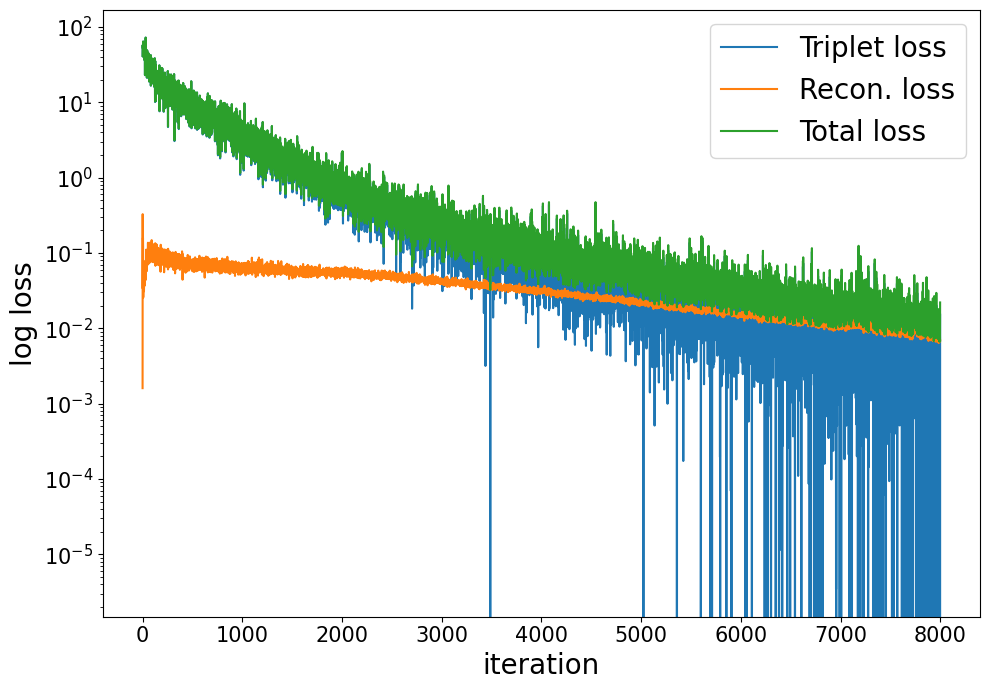

In [8]:
# @title Train autoencoder with lineage triplet loss

torch.cuda.empty_cache()

_ = train_triplet(model=None, model_path=f'{results_path}/ae/{name}_AELR-2-1000_lr1em4_e500_b32_h1_pd_pre_ts12345_hvg.pt',
                  training_seed=12345, n_genes=len(hvg_genes), h=1, gene_matrix=expression[hvg_genes].values,
                  apn_lut_path=f'{data_path}/{name}_apn_pd_triplet_lut.npy', display=True, num_epochs=500, device='cuda:0', batch_size=32,
                  lr=1e-4, init_path=f'{results_path}/ae/{name}_AELR-2-1000_lr1em4_e500_b128_hvg.pt',
                  save_epochs=[100, 250, 500], eval_final_all_if_display=False)



In [9]:
np.random.seed(123121)
gene_tsne = get_tsne(expression[hvg_genes].values)

model = torch.load(f'{results_path}/ae/{name}_AELR-2-1000_lr1em4_e500_b32_h1_pd_pre_ts12345_hvg_e500.pt',
                   map_location=torch.device('cuda:0'))
model.to('cuda:0').eval()
with torch.no_grad():
  _, x_z = model.forward(torch.from_numpy(expression[hvg_genes].values).float().to('cuda:0'), return_z=True)
features =x_z.cpu().numpy()
learnt_tsne = get_tsne(features)

subsets = extract_subsets_with_height(f'{data_path}/{name}_pruned.nwk', 8, labels_in_order)
subtree_10_clusters = subset_labels(subsets, labels_in_order)
node_data, edge_data = get_node_and_edge_data(f'{data_path}/{name}_pruned.nwk')
cell_types = pd.read_csv(f'{data_path}/{name}_cell_types.txt', header=None).values.flatten()
tumors = pd.read_csv(f'{data_path}/{name}_tumors.txt', header=None).values.flatten()
additional_color_domain = np.unique(tumors).tolist()
interactive_plot(node_data, edge_data, labels_in_order,
                 [subtree_10_clusters, cell_types, tumors],
                 ['subtrees', 'cell types', 'primary tumor and metastases'],
                 [gene_tsne, learnt_tsne],
                 ['t-SNE of preprocessed gene expression', 't-SNE of learnt features gene expression'],
                 additional_colors=nice_colors[1:1+len(additional_color_domain)],
                 additional_color_domain=additional_color_domain
                 ).configure_legend(orient='bottom', direction='horizontal')

/home/reroot/porcelan-venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/reroot/porcelan-venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/reroot/porcelan-venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/reroot/porcelan-venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


alt.HConcatChart(...)

## (Q2) Optimization approach to identify interesting genes and lineage subtrees

In this example we apply PORCELAN to a random subset of 1000 cells from the example tumor and metastases to reduce the memory footprint of the computation. In practice (we also do this in the paper), it may be useful to compare results across different random subsets of the cells to check robustness.

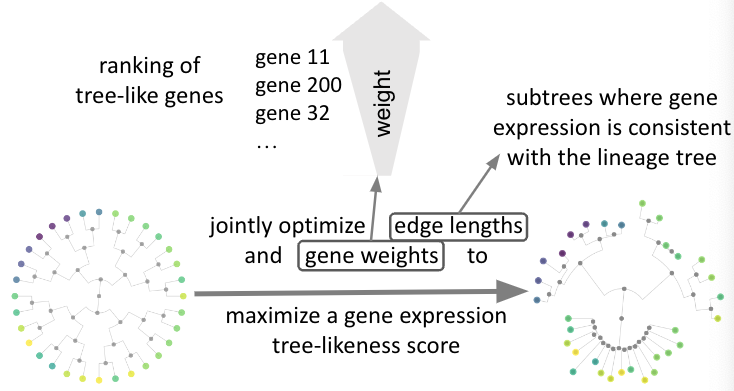

PORCELAN identifies the strongest lineage tree-related expression pattern and genes associated with this pattern. In some cases, e.g., during the development of many different cell types, we might expect mutliple different lineage tree-related expression patterns with different gene sets. In this case we can repeat the below anlysis after removing genes associated with the first pattern identified by PORCELAN to discover further lineage tree-related expression patterns.

In [10]:
# @title Subsample the data and compute tree-likeness scores for all genes

# load data
tree_path = f'{data_path}/{name}_pruned.nwk'
with open(f'{data_path}/{name}_cells.txt') as f:
  labels_in_order = np.array(f.read().splitlines())
expression = pd.read_csv(f'{data_path}/{name}_normalized_log_counts.txt')
expression.index = labels_in_order
cell_meta = pd.read_csv(f'{data_path}/{name}_cell_types.txt', header=None)
cell_meta.columns = ['cell_type']
cell_meta.index = labels_in_order
cell_meta['tumor'] = pd.read_csv(f'{data_path}/{name}_tumors.txt', header=None).values

# subsample
seed = 19442
np.random.seed(seed)
n_cells = len(labels_in_order)
keep_cells = np.random.choice(labels_in_order, size=min(1000,n_cells), replace=False)
expression = expression.loc[keep_cells]
cell_meta = cell_meta.loc[keep_cells]
labels_in_order = keep_cells

etree = Tree(tree_path, format=1, quoted_node_names=True)
print('height before:', etree.get_farthest_leaf()[1])
print('leaves before:', len(etree.get_leaves()))
etree.prune(keep_cells.tolist())
tree_path = f'{data_path}/{name}_pruned_{seed}.nwk'
etree.write(format=1, outfile=tree_path, quoted_node_names=False)
print('height after:', etree.get_farthest_leaf()[1])
print('leaves after:', len(etree.get_leaves()))

# compute tree-likeness score for all genes for unoptimized tree
tree_dists, _ = get_tree_dists(Tree(tree_path, format=1, quoted_node_names=False), labels_in_order)
# gene_scores = get_lac_for_all_genes(tree_dists, expression)
# gene_scores = gene_scores.sort_values('score', ascending=False)
# gene_scores.to_csv(f'{results_path}/{name}_scores_{seed}.csv')
# ordered_genes = gene_scores.index
# print(ordered_genes[:100].values, '...')
from math import ceil
import pandas as pd

# parameters
GENE_CHUNK = 100                # genes per chunk, tune down if still too big
DEVICE     = 'cuda:0'           # or 'cpu' if you prefer

# prepare
tree_obj = Tree(tree_path, format=1, quoted_node_names=False)
tree_dists, _ = get_tree_dists(tree_obj, labels_in_order)

all_genes  = expression.columns.tolist()
n_chunks   = ceil(len(all_genes) / GENE_CHUNK)
scores_acc = []

for chunk_idx in range(n_chunks):
    start = chunk_idx * GENE_CHUNK
    end   = start + GENE_CHUNK
    genes_chunk = all_genes[start:end]
    
    sub_expr = expression[genes_chunk]
    # compute on smaller block
    sub_scores = get_lac_for_all_genes(
      tree_dists,
      sub_expr,
      device=DEVICE
    )
    scores_acc.append(sub_scores)

# stitch them back together
gene_scores = pd.concat(scores_acc).sort_values('score', ascending=False)
gene_scores.to_csv(f'{results_path}/{name}_scores_{seed}.csv')
ordered_genes = gene_scores.index
print("Top 10 genes by tree-likeness:", gene_scores.head(10).index.values)

height before: 20.0
leaves before: 500
height after: 20.0
leaves after: 500
Top 10 genes by tree-likeness: ['Sftpc' 'Clu' 'Sftpb' 'Lyz2' 'Krt19' 'Car2' 'Klf5' 'Rpl37' 'Cldn18'
 'Ager']


epoch: 1000; score: 292.717189586479719; : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:51<00:00, 19.57it/s]
/tmp/ipykernel_88326/549076157.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  loss_fig.show()


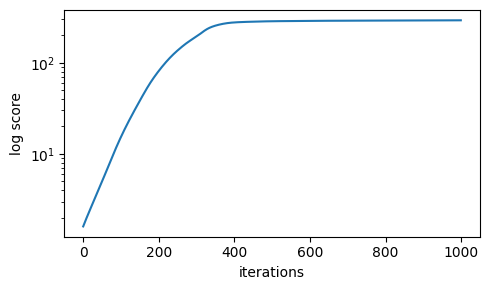

In [11]:
# @title Jointly optimize gene weights and lineage tree edge weights

norm_expression = ((expression - expression.mean(axis=0))/expression.std(axis=0))
model = TreeGeneModel(tree_path, labels_in_order=norm_expression.index, gene_dim=len(ordered_genes), learn_gene_weights=True,
                      skip_tip_distance=-1, decay_factor=10, quoted_node_names=False, initial_weight=0.5)
loss_fig = optimize_weights(model, norm_expression[ordered_genes].values, lr=1e-2, epochs=1000, device='cuda:0', gene_group_size=10)
ewg_df = pd.DataFrame(torch.exp(model.log_edge_weights.detach()).cpu().numpy(),
                     index=model.edges_ends, columns=['weight'])
ewg_df = pd.concat([ewg_df, pd.DataFrame(0.5 * np.ones((len(model.skip_edges_ends), 1)), index=model.skip_edges_ends, columns=['weight'])])
gw_df = pd.DataFrame(torch.nn.functional.softmax(model.log_gene_weights.detach(), dim=0).cpu().numpy(),
                     index=ordered_genes, columns=['weight'])
loss_fig.show()
ewg_df.to_csv(f'{results_path}/{name}_ewg_{seed}.csv')
gw_df.to_csv(f'{results_path}/{name}_gw_{seed}.csv')

del model
gc.collect()
torch.cuda.empty_cache()

In [12]:
# extract tree representations for plotting before and after optimization
show_genes = list(gw_df.sort_values('weight', ascending=False).index[:20])

# with equal edge weights
node_data_a, edge_data_a = get_node_and_edge_data(tree_path)
node_data_a.loc[0, 'cell_label'] = 'N0000'

# with optimized edge weights
etree = augment_tree_with_weights(tree_path, ewg_df['weight'], quoted_node_names=True)
etree.write(outfile=f'{data_path}/temp.nwk', format=1)
node_data_b, edge_data_b = get_node_and_edge_data(f'{data_path}/temp.nwk')
node_data_b.loc[0, 'cell_label'] = 'N0000'

nodes = node_data_a.merge(node_data_b, how='outer', left_on=['cell_label', 'is_leaf'],
                          right_on=['cell_label', 'is_leaf'], suffixes=('_a', '_b'))
edges = edge_data_a.merge(edge_data_b, how='outer', left_index=True, right_index=True, suffixes=('_a', '_b'))

In [13]:
# plot trees before and after optimization colored by cell type and sub-tumor
additional_color_domain = [
    '3515_Lkb1_T1',
    '3515_Lkb1_K2',
    '3515_Lkb1_K3',
    '3515_Lkb1_L2',
    '3515_Lkb1_N1',
    '3515_Lkb1_L1',
    '3515_Lkb1_K1',
]

double_tree_plot(nodes, edges, cell_labels=labels_in_order,
                 colors=[cell_meta['cell_type'].values.flatten(), cell_meta['tumor'].values.flatten()],
                 color_names=['cell_type', 'tumor'],
                 tooltip_names=['cell_label', 'cell_type', 'tumor'], additional_colors=nice_colors[1:1+len(additional_color_domain)],
                 additional_color_domain=additional_color_domain, line_width=2,
                 show_legend=True, continuous_colors=False, width=575).configure_legend(orient='bottom', direction='horizontal')

alt.HConcatChart(...)

In [14]:
# plot trees before and after optimization colored by gene expression
double_tree_plot(nodes, edges, cell_labels=labels_in_order,
                 colors=[norm_expression[gene] for gene in show_genes],
                 color_names=[f'{gene} expression' for gene in show_genes],
                 tooltip_names=['cell_label'],
                 show_legend=True, continuous_colors=True, width=575, line_width=2)

alt.HConcatChart(...)

score unsignificant at\n5% significance level    459
selected                                         140
not selected but\nscore significant               21
Name: color, dtype: int64

 ['Sftpc' 'Clu' 'Sftpb' 'Lyz2' 'Krt19' 'Car2' 'Klf5' 'Rpl37' 'Cldn18'
 'Ager' 'Mcpt1' 'Itm2b' 'Aldoa' 'Marc2' 'Krt20' 'Eif4a1' 'Onecut2'
 'Platr10' 'H2-Aa' 'Pgk1' 'Hp' 'Epcam' 'Vcp' 'Hras' 'Hspa5' 'Rpl13' 'Elf3'
 'S100a14' 'Prdx5' 'Sox17' 'Crlf1' 'Rpl35a' 'Cd24a' 'Rpl5' 'Smarca5'
 'Foxq1' 'Tkt' 'Ssrp1' 'Spint2' 'Ly6d' 'Actr3' 'Cldn4' 'Tff1' 'AY036118'
 'Eef1b2' 'Slc34a2' 'Rpl41' 'Acin1' 'Ctsa' 'Atp2b1' 'Cd81' 'Hmga1-rs1'
 'Sumo1' 'Ap3b2' 'Trim28' 'Maged1' 'Eef2' 'Akirin2' 'Sfpq' 'Ppib' 'Cldn7'
 'Tm9sf3' 'Mrpl24' 'Pdia4' 'Ppp2r1a' 'Eci1' 'Krt18' 'Ehf' 'Ifi27' 'Cbr1'
 'Ctnna1' 'Ssr4' 'Pvrl2' 'Nucb1' 'Cited4' 'Gm9774' 'Sbds' 'Prdx2' 'Rab25'
 'Fubp1' 'Grina' 'Stmn2' 'Kifc2' 'Atp5b' 'Ctsh' 'Rps18' 'Serpini1'
 'Anapc5' 'Ifitm2' 'Eif6' 'Rps11' 'Cyba' 'Rsl1d1' 'Rpl35' 'Ctsl' 'Vamp8'
 'Egfl6' 'Tomm20' 'Matn4' 'G

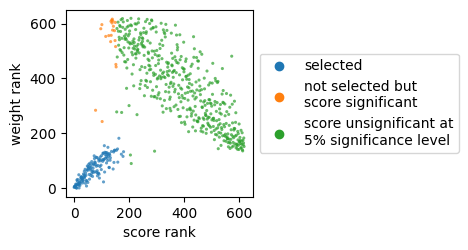

In [15]:
# @title Select gene set based on score and weight ranks

# Rank comparison to select genes
gene_rank_df = pd.DataFrame(index=ordered_genes)
gene_rank_df['score rank'] = np.argsort(np.argsort(-gene_scores.loc[ordered_genes]['score']))
gene_rank_df['weight rank'] = np.argsort(np.argsort(-gw_df.loc[ordered_genes]['weight']))
gene_rank_df['color'] = 'score <= 1.64'
gene_rank_df.loc[gene_scores.loc[ordered_genes]['score'] > 1.64, 'color'] = 'score > 1.64'
gene_rank_df.loc[(gene_rank_df['score rank'] < 200) & (gene_rank_df['weight rank'] < 200), 'color'] = 'agree'

gene_rank_df['color'] = gene_rank_df['color'].replace({'agree':'selected',
                                                       'score <= 1.64':'score unsignificant at\n5% significance level',
                                                       'score > 1.64':'not selected but\nscore significant'})
gene_rank_df[gene_rank_df['color'] == 'selected'].to_csv(f'{results_path}/{name}_agree_genes_{seed}.txt', columns=[], header=False)

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
sns.scatterplot(gene_rank_df, x='score rank', y='weight rank', s=5, edgecolor='none', hue='color', alpha=0.7, ax=ax)
sns.move_legend(
    ax, "center left",
    bbox_to_anchor=(1.0, 0.5), ncol=1, title=None,
)

print(gene_rank_df['color'].value_counts())
ax.set_aspect(1)
fig.tight_layout(w_pad=5)

all_genes = gene_rank_df.index.values.tolist()
selected = gene_rank_df[gene_rank_df['color'] == 'selected'].index.values.tolist()
print('\n', np.array(selected))

In [16]:
# @title GO-term analysis
enr_all = gseapy.enrichr(gene_list=all_genes, gene_sets='GO_Biological_Process_2023', organism='mouse', verbose=False)
terms_all = set(enr_all.results[enr_all.results['Adjusted P-value'] <= 0.05]['Term'].values)
time.sleep(1)  # gseapy.enrichr doesn't allow fast successive API calls
enr = gseapy.enrichr(gene_list=selected, gene_sets='GO_Biological_Process_2023', organism='mouse', verbose=False)
terms_selected = set(enr.results[enr.results['Adjusted P-value'] <= 0.05]['Term'].values)

df = enr.results[['Term', 'Adjusted P-value']].copy()
df['Adjusted P-value using all genes'] = enr_all.results.set_index('Term').loc[df['Term'], 'Adjusted P-value'].values
df.to_csv(f'{results_path}/{name}_selected_genes_{seed}.csv', index=False)
df[df['Adjusted P-value'] <= 0.05]

Term  Adjusted P-value  \
0     Macromolecule Biosynthetic Process (GO:0009059)      5.106505e-07   
1                Cytoplasmic Translation (GO:0002181)      5.106505e-07   
2                            Translation (GO:0006412)      3.605549e-06   
3           Peptide Biosynthetic Process (GO:0043043)      3.776833e-06   
4                        Gene Expression (GO:0010467)      3.416612e-05   
5   Positive Regulation Of Peptidase Activity (GO:...      1.256056e-04   
6   Negative Regulation Of Apoptotic Process (GO:0...      2.177296e-02   
7                       Bone Development (GO:0060348)      3.187352e-02   
8   Calcium-Independent Cell-Cell Adhesion Via Pla...      3.379219e-02   
9        Epithelial Cell Differentiation (GO:0030855)      3.409258e-02   
10                     Ribosome Assembly (GO:0042255)      3.751713e-02   
11                rRNA Metabolic Process (GO:0016072)      3.751713e-02   
12               Tight Junction Assembly (GO:0120192)      3.751713e-02   
13              Apical Junction Assembly (GO:0043297)      3.751713e-02   
14    Ribosomal Large Subunit Biogenesis (GO:0042273)      3.751713e-02   
15                       rRNA Processing (GO:0006364)      4.432004e-02   
16                Epithelium Development (GO:0060429)      4.432004e-02   
17                   Ribosome Biogenesis (GO:0042254)      4.432004e-02   

    Adjusted P-value using all genes  
0                           0.000156  
1                           0.083896  
2                           0.003561  
3                           0.004501  
4                           0.002619  
5                           0.004501  
6                           0.080757  
7                           0.457495  
8                           0.317606  
9                           0.477857  
10                          0.317606  
11                          0.340575  
12                          0.110907  
13                          0.115805  
14                          0.573681  
15                          0.405676  
16                          0.467558  
17                          0.609460

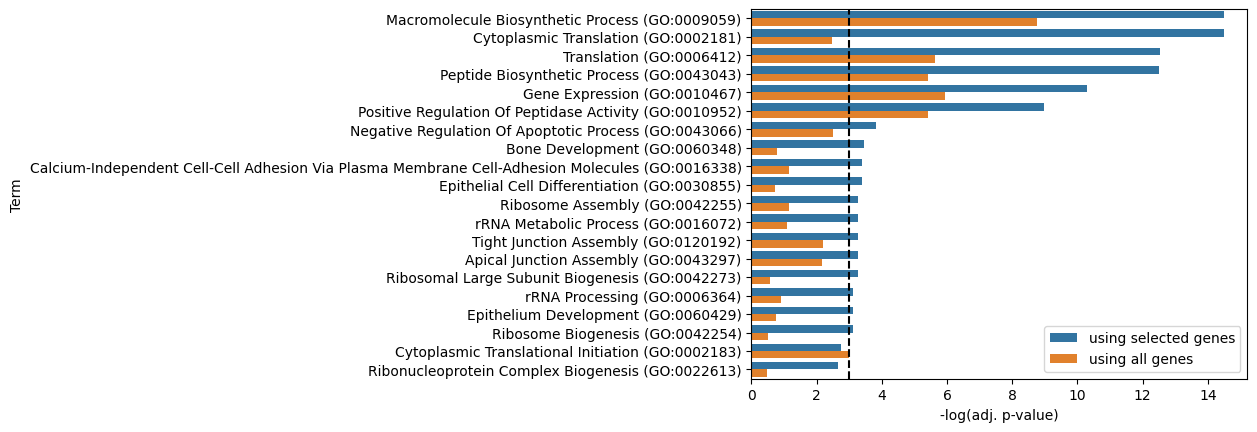

In [17]:
df = (-pd.read_csv(f'{results_path}/{name}_selected_genes_{seed}.csv').rename(
    columns={'Adjusted P-value':'using selected genes', 'Adjusted P-value using all genes':'using all genes'}
).set_index('Term').apply(np.log)).reset_index()[:20]
mdf = pd.melt(df, id_vars=['Term'], value_vars=['using selected genes', 'using all genes'], value_name='-log(adj. p-value)')
sns.barplot(mdf, y='Term', x='-log(adj. p-value)', orient='h', hue='variable')
plt.gca().legend().set_title('')
plt.axvline(-np.log(0.05), color='k', ls='--')

## (Q3) Permutation strategy to interrogate gene expression memory maintenance

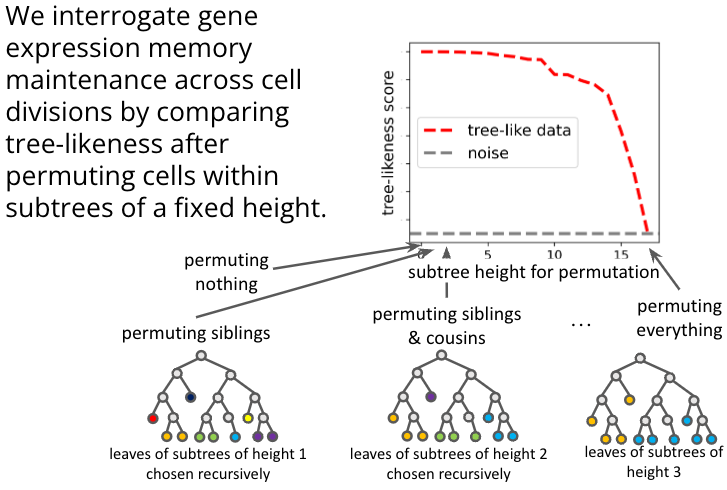

### Using local autocorrelation

In this subsection we use local autocorrelation computed directly from gene expression as our tree-likeness score.

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.50it/s]


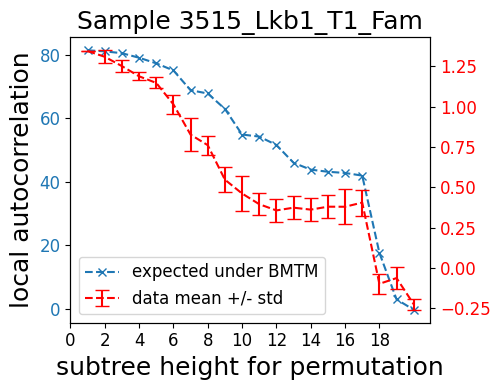

In [18]:
with open(f'{data_path}/{name}_cells.txt') as f:
  labels_in_order = np.array(f.read().splitlines())

expression = pd.read_csv(f'{data_path}/{name}_normalized_log_counts.txt')
expression.index = labels_in_order

etree = Tree(f'{data_path}/{name}_pruned.nwk', quoted_node_names=True, format=1)
expected_lac = get_expected_lac_bmtm_height_perm(etree, expression.index)
agg = get_perm_dists(expression, tree_path=f'{data_path}/{name}_pruned.nwk')

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(expected_lac['height'], expected_lac['lac'], 'x--', label='expected under BMTM')
ax.set_xlabel('subtree height for permutation', fontsize=18)
ax.set_ylabel('local autocorrelation', fontsize=18)
ax.tick_params(axis='x', which='major', labelsize=12)
ax.tick_params(axis='y', which='major', labelsize=12, labelcolor='tab:blue')
ax.set_title(f'Sample {name}', fontsize=18)
ax2 = ax.twinx()
ax2.errorbar(agg.index, agg[f'la_expression_mean'], yerr=agg[f'la_expression_std'],
              label=f'data mean +/- std', color='red', fmt='--', capsize=5)
ax2.tick_params(axis='y', which='major', labelsize=12, labelcolor='red')
ax.set_xticks(expected_lac.index.values[::2].tolist())

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, prop={'size': 12}, loc='lower left')

fig.tight_layout()

We can also apply the previous approach to each cell type separately (this would be more interesting for samples with multiple cell types than this sample which is mostly just labeled "Pre-EMT"):

Pre-EMT                 448
Endoderm-like            14
AT2-like                 10
Lkb1 subtype              8
Early EMT-2               5
Lung progenitor-like      4
AT1-like                  3
Early EMT-1               3
High plasticity           1
Gastric-like              1
Mesenchymal-2 (Met)       1
Mesenchymal-2             1
Late Gastric              1
Name: cell_type, dtype: int64


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 22.02it/s]
/tmp/ipykernel_88326/222182064.py:42: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


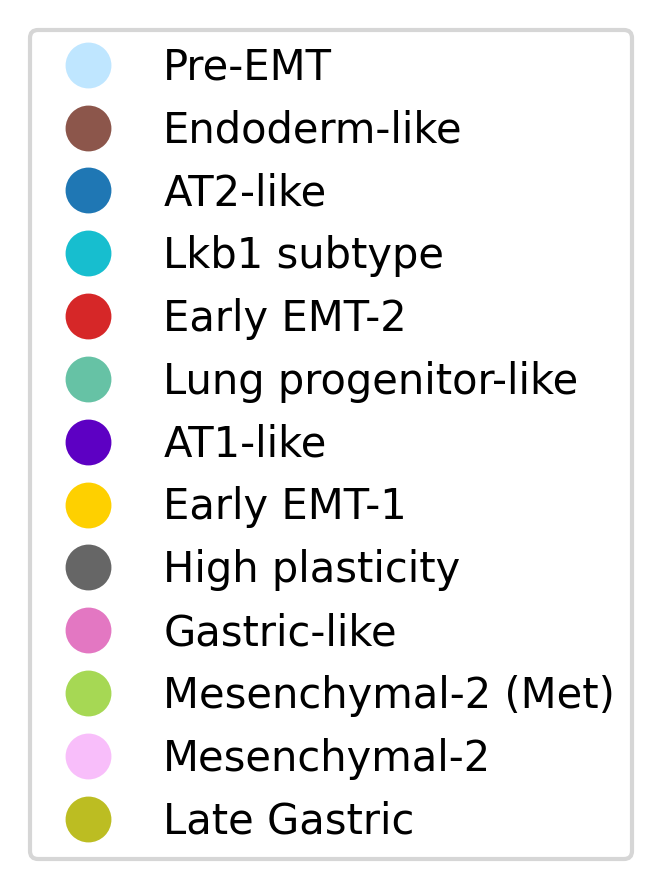

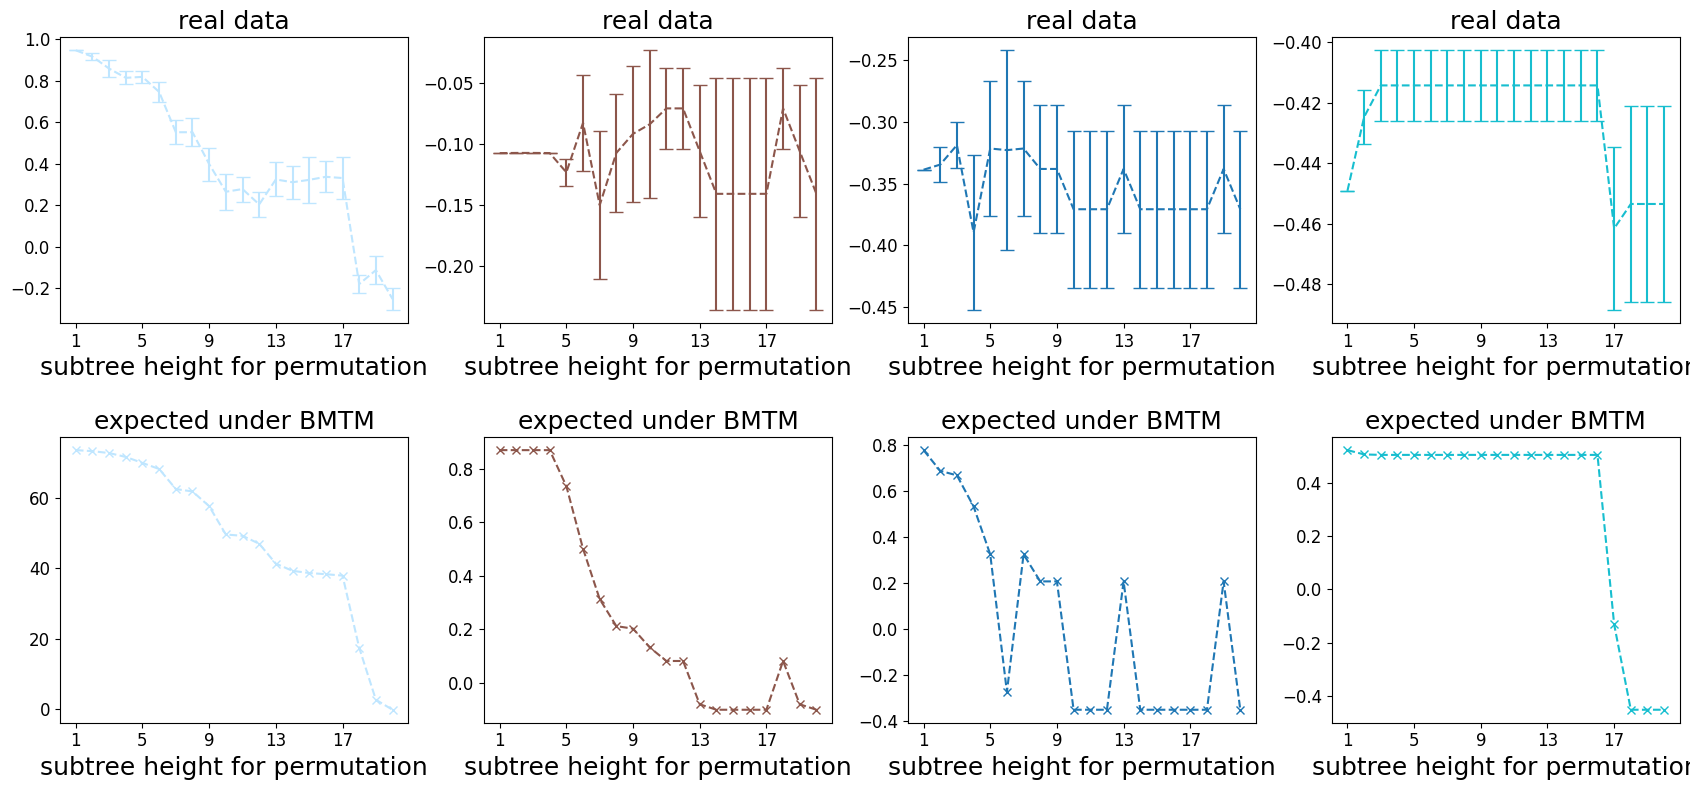

In [19]:
# load data
tree_path = f'{data_path}/{name}_pruned.nwk'
etree = Tree(tree_path, quoted_node_names=True, format=1)
with open(f'{data_path}/{name}_cells.txt') as f:
  labels_in_order = np.array(f.read().splitlines())
expression = pd.read_csv(f'{data_path}/{name}_normalized_log_counts.txt')
expression.index = labels_in_order
cell_meta = pd.read_csv(f'{data_path}/{name}_cell_types.txt', header=None)
cell_meta.columns = ['cell_type']
cell_meta.index = labels_in_order
cell_meta['tumor'] = pd.read_csv(f'{data_path}/{name}_tumors.txt', header=None).values

# compute scores
aggs = {}
expected_lacs = {}
vc = cell_meta['cell_type'].value_counts()
print(vc)
main_types = vc.index[:4]
for t in main_types:
  subtree_labels = cell_meta[cell_meta['cell_type'] == t].index.values if t != 'All' else None
  expected_lacs[t] = get_expected_lac_bmtm_height_perm(etree, expression.index, labels_subset=subtree_labels)
  aggs[t] = get_perm_dists(expression, tree_path=tree_path, subtree_labels=subtree_labels)

with open(f'{results_path}/{name}_expected_lac.pk', 'wb') as handle:
  pickle.dump(expected_lacs, handle)
with open(f'{results_path}/{name}_real_lac.pk', 'wb') as handle:
  pickle.dump(aggs, handle)


# make legend
color_df = pd.DataFrame(index=kp_color_domain)
color_df['color'] = nice_colors
color_df = color_df.loc[cell_meta['cell_type'].value_counts().index]
legend_elements = []
for color, cell_type in zip(color_df['color'], color_df.index):
  legend_elements.append(Line2D([0], [0], marker='o', lw=0, color=color, label=cell_type, markersize=10))

fig, ax = plt.subplots(figsize=(2, 2), dpi=300)
ax.axis('off')
ax.legend(handles=legend_elements, loc='center', ncol=1)
fig.tight_layout()
fig.show()

# plot scores
color_df.loc['All', 'color'] = '#000000'
dist_id = 'la'
fig, axxs = plt.subplots(2, 4, figsize=(17, 8))
for i, t in enumerate(main_types):
  agg = aggs[t]
  expected_lac = expected_lacs[t]
  axs = axxs.T[i]

  ax2 = axs[0]
  ax2.errorbar(agg.index, agg[f'{dist_id}_expression_mean'], yerr=agg[f'{dist_id}_expression_std'],
              label=f'{t}', color=color_df.loc[t, 'color'], fmt='--', capsize=5)
  ax2.set_xlabel('subtree height for permutation', fontsize=18)
  ax2.tick_params(axis='both', which='major', labelsize=12)
  ax2.set_title(f'real data', fontsize=18)

  a = (agg[f'{dist_id}_expression_mean'] - agg[f'{dist_id}_expression_std']).min()
  b = (agg[f'{dist_id}_expression_mean'] + agg[f'{dist_id}_expression_std']).max()
  ax2.set_ylim(a - 0.05 * (b - a), b + 0.05 * (b - a))
  ax2.set_xticks(agg.index.values[::4].tolist())

  ax = axs[1]
  ax.plot(expected_lac['height'], expected_lac['lac'], 'x--', color=color_df.loc[t, 'color'])
  ax.set_xlabel('subtree height for permutation', fontsize=18)
  ax.tick_params(axis='both', which='major', labelsize=12)
  ax.set_title(f'expected under BMTM', fontsize=18)
  ax.set_xticks(axs[0].get_xticks())

fig.tight_layout()
fig.subplots_adjust(hspace=0.4)

### Using the autoencoder lineage triplet loss

The more lineage structure is contained in gene expression, the easier it is easier for the autoencoder to learn lineage tree-structured representations. So the negated triplet loss of an autoencoder trained for a fixed number of epochs can be used as a tree likeness score for relative comparisons. In this subsection we use this score.

Since it will take several hours to train all of the autoencoders for the different
permutation subtree heights, training, and permutation random seeds, we recommend running the below cells in a `screen` session in your terminal.

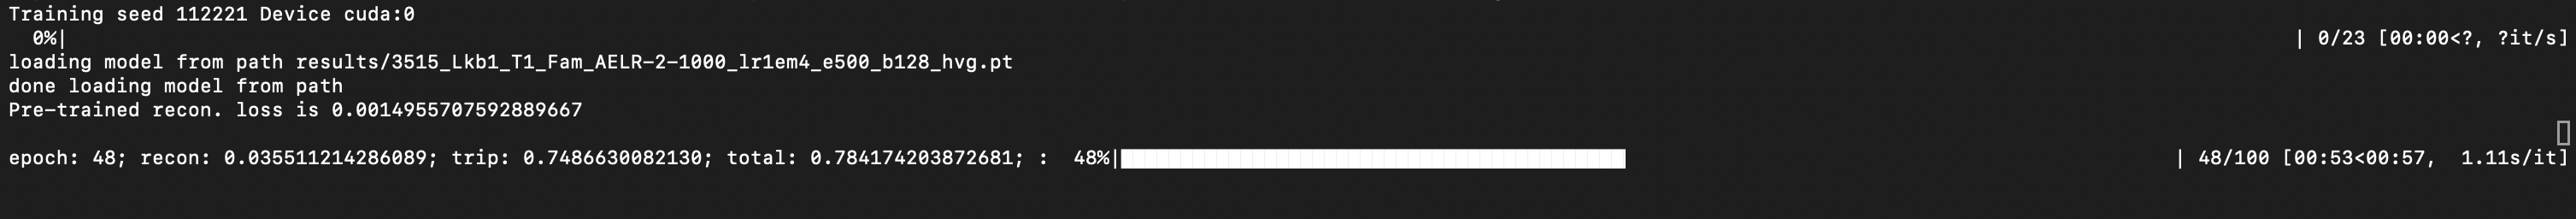

Alternatively, you can run the cell below in this jupyter notebook. However, the progress bar may not display properly and it may print many lines of updates instead.




In [ ]:
# Train autoencoder with lineage triplet loss on permuted data

# %cd tutorial/
# !python ../train_perm_tumor_aes.py -t '3515_Lkb1_T1_Fam' -m '_hvg' -d 22 -c 'cuda:0' -k 'AELR-2-1000'
# %cd ..

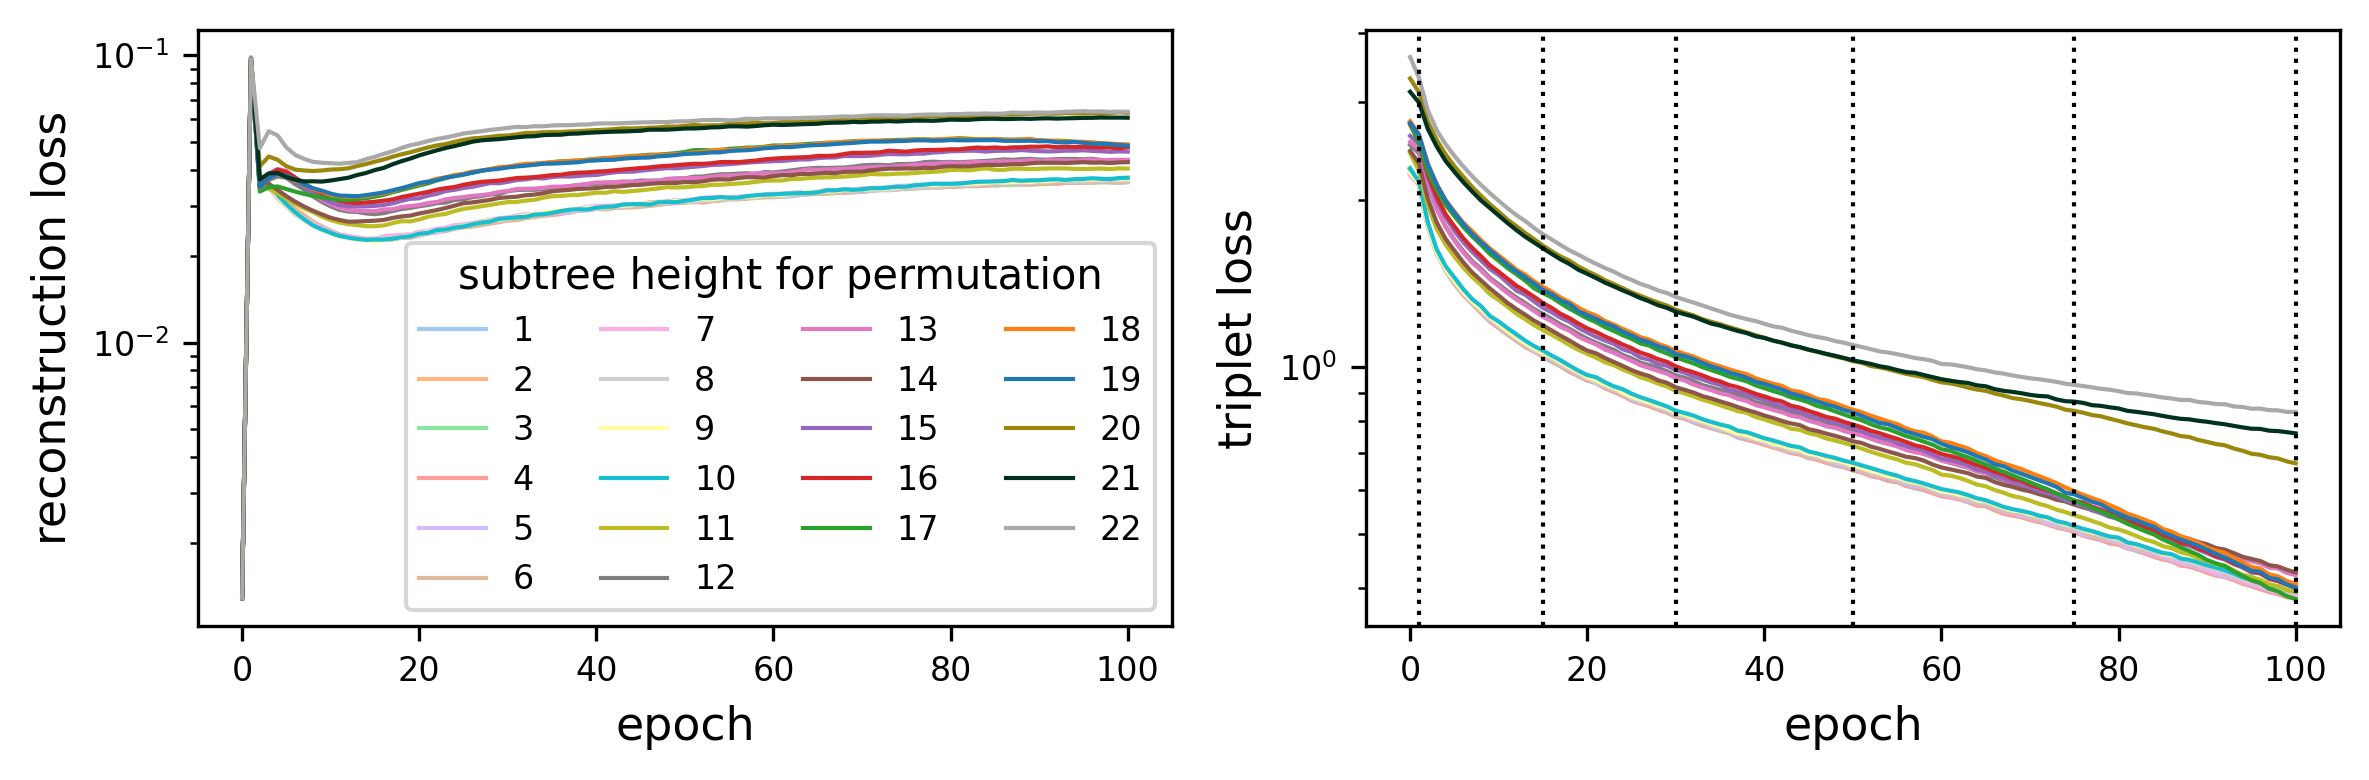

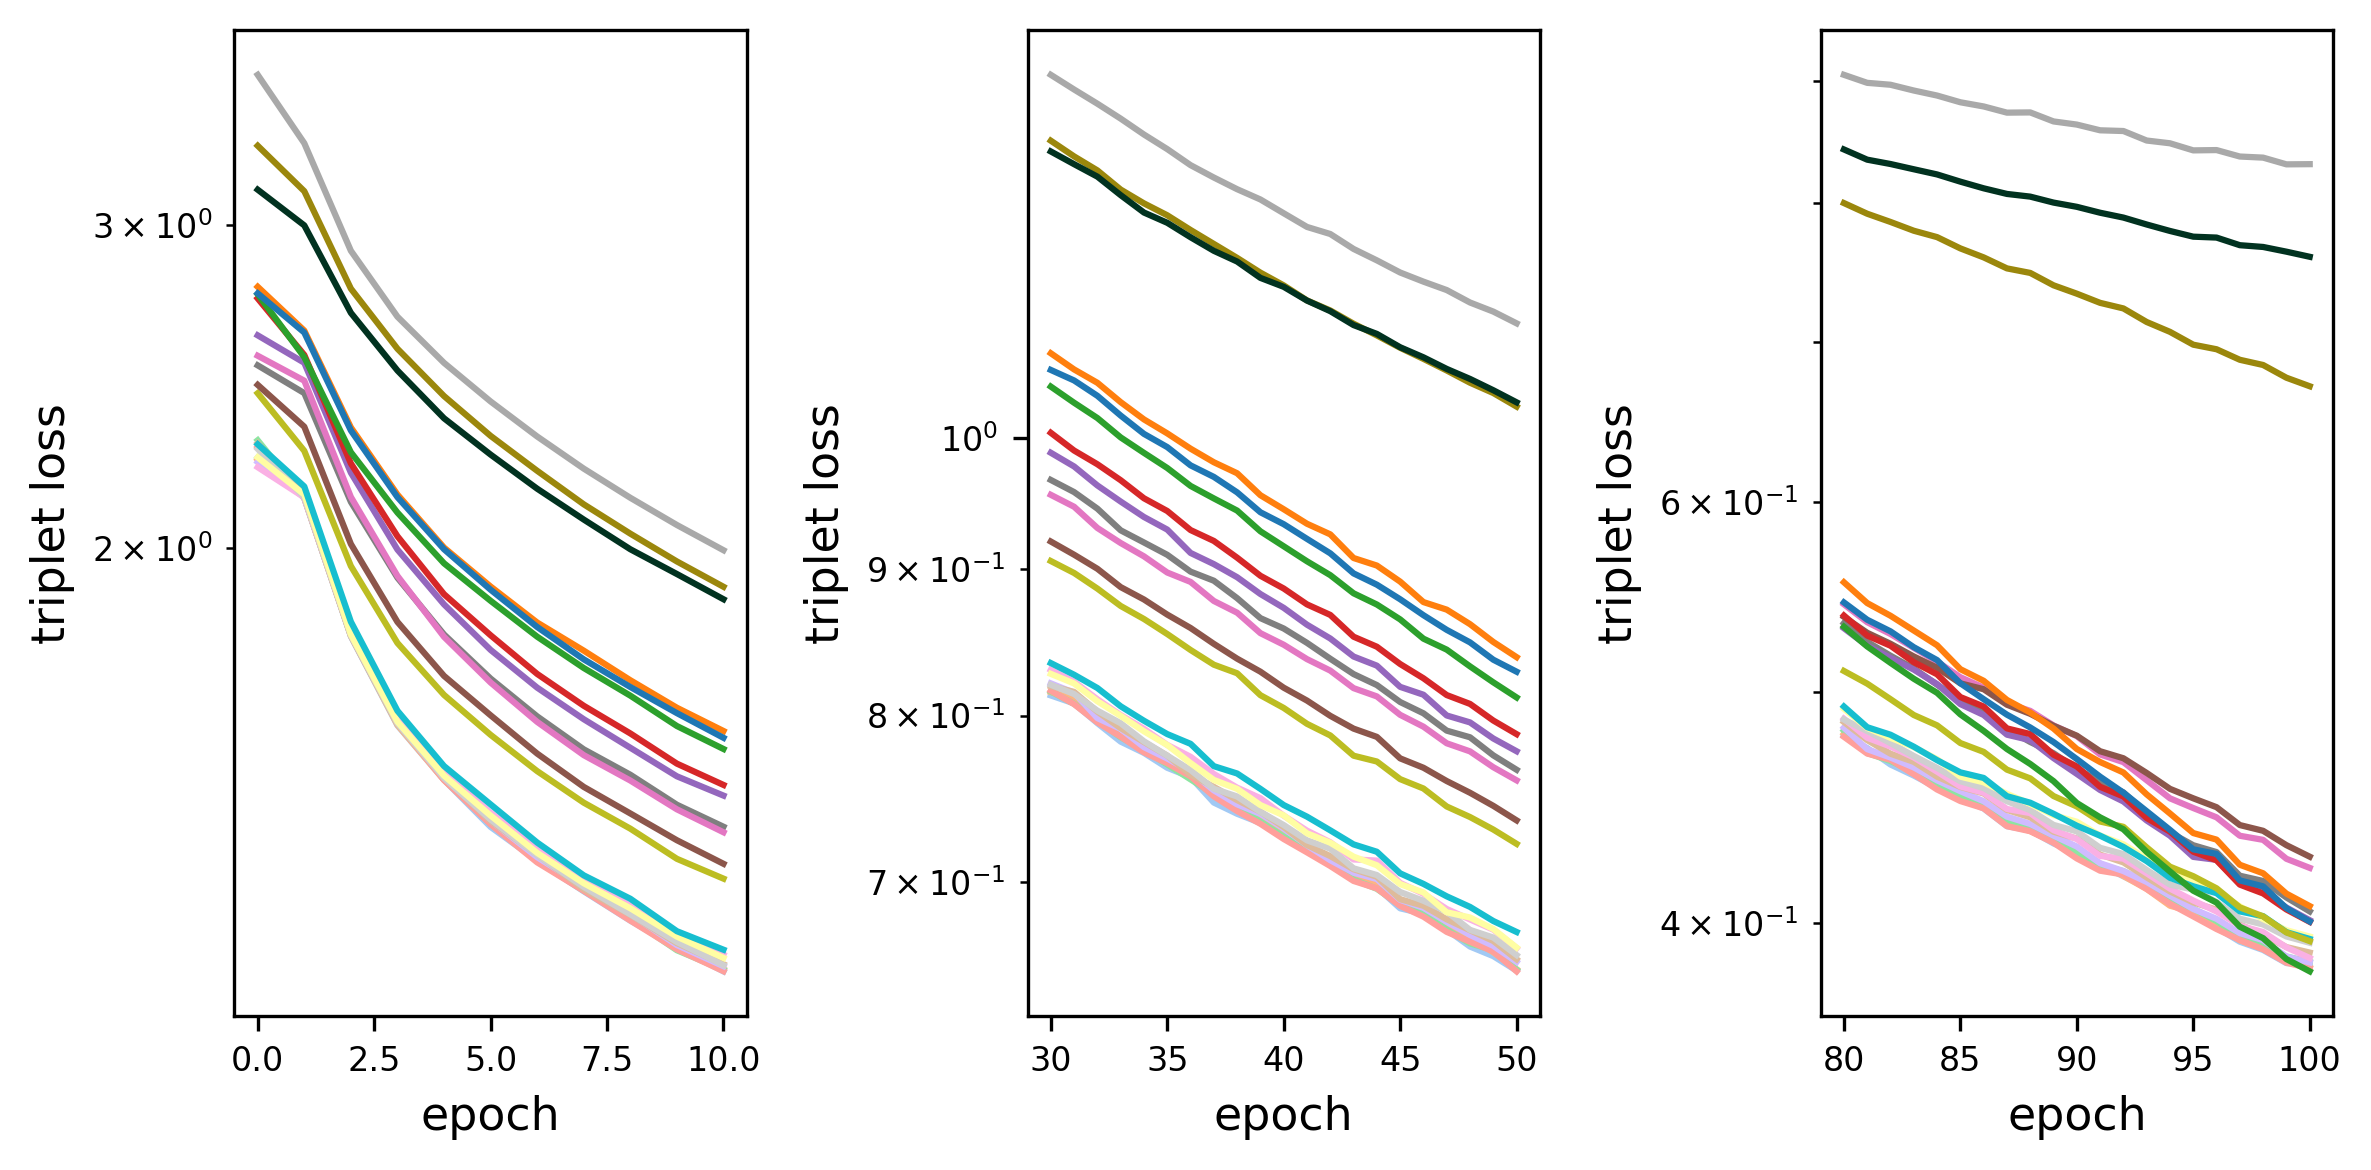

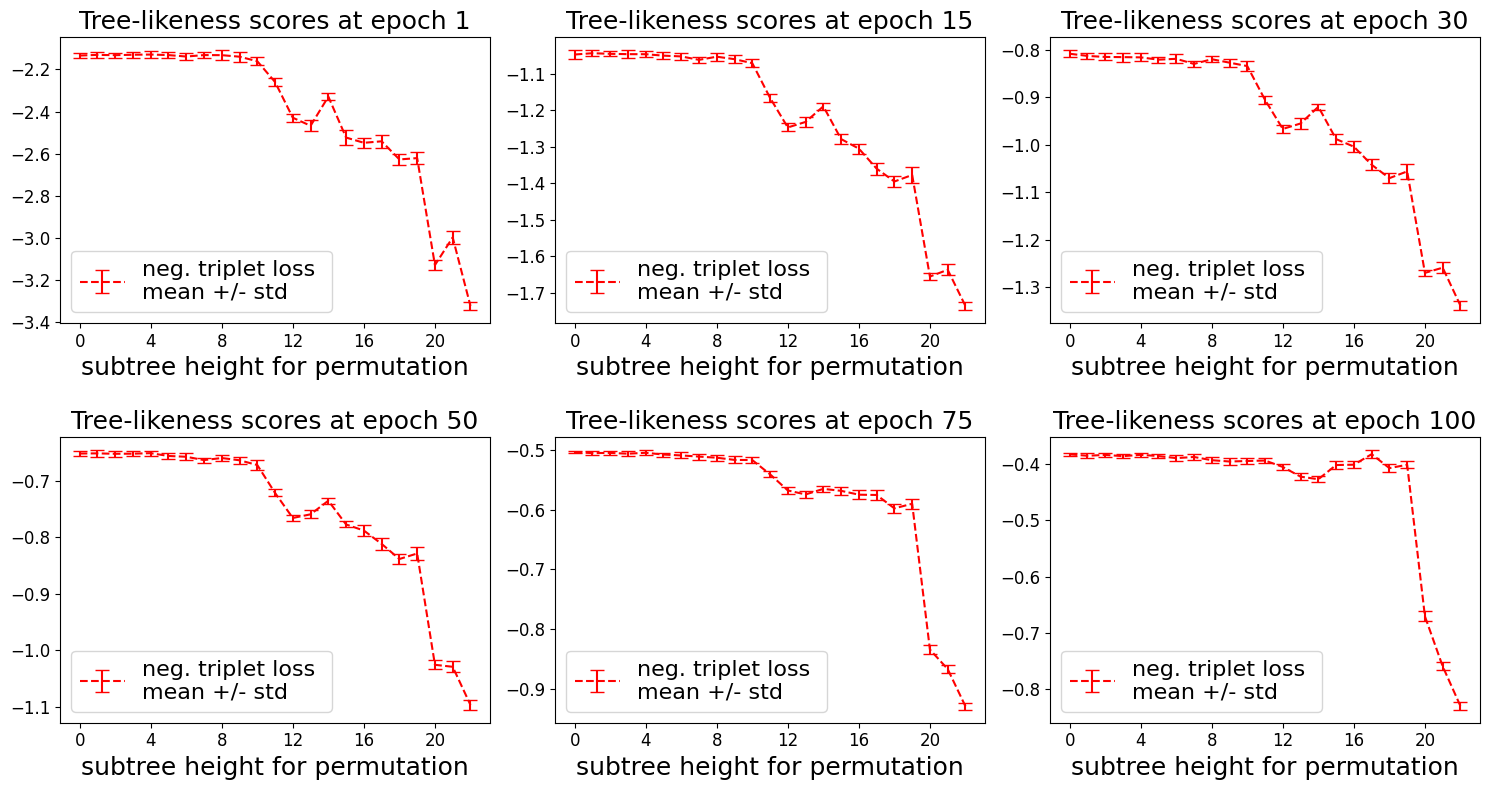

In [13]:
max_epoch = 100
max_height = 22
training_seeds = [112221, 99483, 92231, 6243321, 555242]
perm_seeds = [12345, 66689, 41382, 3838374, 12311]
stops = [1, 15, 30, 50, 75, 100]

# aggregate losses
df = pd.DataFrame()
batches_per_epoch = 0
for training_seed in training_seeds:
  for perm_seed in perm_seeds:
    # without permutation (d=0) only need one model per training seed
    for h in range(0 if perm_seed == perm_seeds[0] else 1, max_height+1):
      loss_path = f'{results_path}/ae/{name}_AELR-2-1000_lr1em4_e{max_epoch}_b128_h1_pd_pre_ts{training_seed}_perm{perm_seed}d{h}_g100_hvg_loss.csv'
      dfi = pd.read_csv(loss_path)
      dfi[['training_seed', 'perm_seed', 'height']] = training_seed, perm_seed, h
      dfi = dfi.rename(columns={'recon_loss': 'rec_loss'})
      df = pd.concat([df, dfi])
      batches_per_epoch = len(dfi) // max_epoch  # same for all
df['epoch'] = df['iter'] // batches_per_epoch + 1

df_stops = pd.DataFrame()
for stop in stops:
  df_epoch = df[df['epoch'] == stop].groupby(['training_seed', 'perm_seed', 'height'])[['trip_loss', 'rec_loss']].mean().reset_index()
  df_epoch['stop'] = stop
  df_stops = pd.concat([df_stops, df_epoch])

# add epoch 0 copied from iter 0
epoch_agg = df.groupby(['height', 'epoch', 'training_seed', 'perm_seed']).mean().reset_index()
iter0_agg = df[df['iter'] == 0].groupby(['height', 'epoch', 'training_seed', 'perm_seed']).mean().reset_index()
iter0_agg['epoch'] = 0
epoch_agg = pd.concat((iter0_agg, epoch_agg))
epoch_agg = epoch_agg.groupby(['height', 'epoch']).agg(
  rec_mean=pd.NamedAgg(column="rec_loss", aggfunc="mean"),
  rec_min=pd.NamedAgg(column="rec_loss", aggfunc="min"),
  rec_max=pd.NamedAgg(column="rec_loss", aggfunc="max"),
  trip_mean=pd.NamedAgg(column="trip_loss", aggfunc="mean"),
  trip_min=pd.NamedAgg(column="trip_loss", aggfunc="min"),
  trip_max=pd.NamedAgg(column="trip_loss", aggfunc="max"))
epoch_agg = epoch_agg.reset_index()


# makes plots of losses for different permutation heights
num_colors = len(epoch_agg['height'].unique())
assert num_colors <= 23
num_colors -= 3
cm1 = plt.get_cmap('tab10')
cm2 = sns.color_palette('pastel', as_cmap=True)
colors =  [cm2[i] for i in range(num_colors - 10 - 1)] + [cm1(9 - i) for i in range(10)] + ['#9b870c', '#013220', '#A9A9A9']

fig, axs = plt.subplots(1, 2, figsize=(8, 2.7), dpi=300)
axs[0].set_prop_cycle(color=colors)
axs[1].set_prop_cycle(color=colors)
for h in range(1, max_height+1, 1):
  aggd = epoch_agg[(epoch_agg['height'] == h)]
  axs[1].plot(aggd['epoch'], aggd['trip_mean'], label=f'{h}', lw=1)
  axs[0].plot(aggd['epoch'], aggd['rec_mean'], label=f'{h}', lw=1)
for ax in axs[:1]:
  ax.legend(prop={'size':8}, ncol=4, title='subtree height for permutation')
for ax in axs[1:]:
  for stop in stops:
    ax.axvline(stop, color='black', linestyle=':', lw=1)
for ax in axs:
  ax.set_yscale('log')
  ax.tick_params(axis='both', which='both', labelsize=8)
  ax.set_xlabel('epoch', fontsize=11)
axs[1].set_ylabel('triplet loss', fontsize=11)
axs[0].set_ylabel('reconstruction loss', fontsize=11)
fig.tight_layout()


fig, axs = plt.subplots(1, 3, figsize=(8, 4), dpi=300)
num_colors = len(epoch_agg['height'].unique())
for ax in axs:
  ax.set_prop_cycle(color=colors)
ranges = [(0, 10), (30, 50), (80, 100)]
for ax, ran in zip(axs, ranges):
  for h in range(1, max_height+1, 1):
    aggd = epoch_agg[(epoch_agg['height'] == h) & (epoch_agg['epoch'] >= ran[0]) & (epoch_agg['epoch'] <= ran[1])]
    ax.plot(aggd['epoch'], aggd['trip_mean'], label=f'{h}')
for ax in axs:
  ax.set_yscale('log')
  ax.tick_params(axis='both', which='both', labelsize=8)
  ax.set_xlabel('epoch', fontsize=11)
  ax.set_ylabel('triplet loss', fontsize=11)
fig.tight_layout()


fig, axs = plt.subplots(2, 3, figsize=(15, 8))
for stop, ax2 in zip(stops, axs.flatten()):
  agg = df_stops[df_stops['stop'] == stop].groupby('height').agg(
    trip_mean=pd.NamedAgg(column="trip_loss", aggfunc="mean"),
    trip_std=pd.NamedAgg(column="trip_loss", aggfunc="std"),
    trip_med=pd.NamedAgg(column="trip_loss", aggfunc="median"),
    trip_min=pd.NamedAgg(column="trip_loss", aggfunc="min"),
    trip_max=pd.NamedAgg(column="trip_loss", aggfunc="max"))

  ax2.errorbar(agg.index, -agg['trip_mean'], yerr=agg['trip_std'], label='neg. triplet loss \nmean +/- std', color='red', fmt='--', capsize=5)
  ax2.legend(prop={'size': 16})
  ax2.set_xlabel('subtree height for permutation', fontsize=18)
  ax2.tick_params(axis='both', which='major', labelsize=12)
  ax2.set_title(f'Tree-likeness scores at epoch {stop}', fontsize=18)

  a, b = (-agg['trip_mean'] - agg['trip_std']).min(), (-agg['trip_mean'] + agg['trip_std']).max()
  ax2.set_ylim(a - 0.05 * (b - a), b + 0.05 * (b - a))
  ax2.set_xticks(agg.index.values[::4].tolist())
fig.tight_layout()
fig.subplots_adjust(hspace=0.4)